In [1]:
!pip install torch torchvision transformers ultralytics pillow matplotlib opencv-python

   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/1.0 MB 25.1 MB/s eta 0:00:00

   ---------------------------------------- 0/3 [py-cpuinfo]
   ------------- -------------------------- 1/3 [ultralytics-thop]
   -------------------------- ------------- 2/3 [ultralytics]
   -------------------------- ------------- 2/3 [ultralytics]
   -------------------------- ------------- 2/3 [ultralytics]
   -------------------------- ------------- 2/3 [ultralytics]
   -------------------------- ------------- 2/3 [ultralytics]
   -------------------------- ------------- 2/3 [ultralytics]
   -------------------------- ------------- 2/3 [ultralytics]
   -------------------------- ------------- 2/3 [ultralytics]
   -------------------------- ------------- 2/3 [ultralytics]
   -------------------------- ------------- 2/3 [ultralytics]
   -------------------------- ------------- 2/3 [ultralytics]
   -------------------------- -------------

=== Single Image Analysis ===

image 1/1 C:\Users\scott\OneDrive\Documents\DevBox\Python\AI_Projects\ai_cyberforensics\object_detection\..\datasets\images\objects\raw\knife_161.jpg: 640x640 1 person, 1 knife, 831.5ms
Speed: 5.8ms preprocess, 831.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Image: ../datasets/images/objects/raw/knife_161.jpg
Total detections: 2
Forensic score: 10.00

🚩 FORENSIC EVIDENCE DETECTED:
  - PEOPLE: person (confidence: 0.81)
  - WEAPONS: knife (confidence: 0.96)

image 1/1 C:\Users\scott\OneDrive\Documents\DevBox\Python\AI_Projects\ai_cyberforensics\object_detection\..\datasets\images\objects\raw\knife_161.jpg: 640x640 1 person, 1 knife, 887.5ms
Speed: 5.2ms preprocess, 887.5ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)
Visualization saved to: analysis_result.jpg


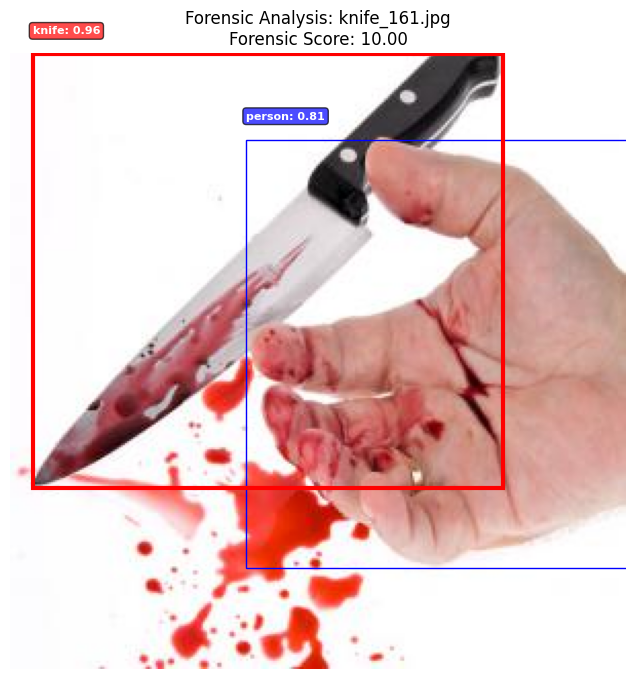


=== Batch Analysis Example ===
To analyze a directory of images:
results = detector.batch_analyze('suspect_photos/', 'forensic_report.json')


In [6]:
"""
RT-DETR Implementation for Digital Forensics
Real-Time Detection Transformer for evidence identification
"""

import torch
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
import json
from datetime import datetime

# Installation requirements:
# pip install torch torchvision ultralytics pillow matplotlib opencv-python

class ForensicRTDETR:
    def __init__(self, model_size='rtdetr-l'):
        """
        Initialize RT-DETR model for forensic analysis

        Args:
            model_size: 'rtdetr-n', 'rtdetr-s', 'rtdetr-m', 'rtdetr-l', 'rtdetr-x'
                       (n=nano/fastest, x=extra-large/most accurate)
        """
        from ultralytics import RTDETR

        self.model = RTDETR(f'{model_size}.pt')
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model.to(self.device)

        # Forensically relevant COCO classes
        self.forensic_classes = {
            'weapons': ['knife', 'scissors'],
            'electronics': ['cell phone', 'laptop', 'tv', 'keyboard', 'mouse', 'remote'],
            'vehicles': ['car', 'motorcycle', 'truck', 'bus', 'bicycle'],
            'containers': ['suitcase', 'handbag', 'backpack', 'bottle'],
            'documents': ['book'],
            'tools': ['scissors'],
            'people': ['person']
        }

    def analyze_image(self, image_path, confidence_threshold=0.3):
        """
        Analyze single image for forensic evidence

        Args:
            image_path: Path to image file
            confidence_threshold: Minimum confidence for detections

        Returns:
            dict: Analysis results with detections and forensic assessment
        """
        # Run detection
        results = self.model(image_path, conf=confidence_threshold)

        # Process results
        detections = []
        forensic_flags = []

        for result in results:
            boxes = result.boxes
            if boxes is not None:
                for i in range(len(boxes)):
                    # Extract detection info
                    box = boxes.xyxy[i].cpu().numpy()
                    conf = float(boxes.conf[i].cpu().numpy())
                    cls_id = int(boxes.cls[i].cpu().numpy())
                    class_name = self.model.names[cls_id]

                    detection = {
                        'bbox': box.tolist(),
                        'confidence': conf,
                        'class': class_name,
                        'class_id': cls_id
                    }
                    detections.append(detection)

                    # Check for forensically relevant items
                    forensic_category = self._categorize_forensic_item(class_name)
                    if forensic_category:
                        forensic_flags.append({
                            'category': forensic_category,
                            'item': class_name,
                            'confidence': conf,
                            'bbox': box.tolist()
                        })

        return {
            'image_path': str(image_path),
            'timestamp': datetime.now().isoformat(),
            'total_detections': len(detections),
            'detections': detections,
            'forensic_flags': forensic_flags,
            'forensic_score': self._calculate_forensic_score(forensic_flags)
        }

    def batch_analyze(self, image_directory, output_file=None):
        """
        Analyze multiple images for forensic evidence

        Args:
            image_directory: Directory containing images
            output_file: Optional JSON file to save results

        Returns:
            list: Analysis results for all images
        """
        image_dir = Path(image_directory)
        supported_formats = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
        image_files = [f for f in image_dir.glob('*') if f.suffix.lower() in supported_formats]

        results = []
        for image_file in image_files:
            print(f"Analyzing: {image_file.name}")
            try:
                result = self.analyze_image(image_file)
                results.append(result)
            except Exception as e:
                print(f"Error analyzing {image_file}: {e}")

        # Sort by forensic score (highest first)
        results.sort(key=lambda x: x['forensic_score'], reverse=True)

        if output_file:
            with open(output_file, 'w') as f:
                json.dump(results, f, indent=2)
            print(f"Results saved to: {output_file}")

        return results

    def visualize_detections(self, image_path, save_path=None):
        """
        Create visualization of detections with forensic highlighting
        """
        # Load image
        image = cv2.imread(str(image_path))
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Get analysis results
        analysis = self.analyze_image(image_path)

        # Create plot
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        ax.imshow(image_rgb)

        # Draw detections
        for detection in analysis['detections']:
            bbox = detection['bbox']
            class_name = detection['class']
            confidence = detection['confidence']

            # Determine color based on forensic relevance
            forensic_cat = self._categorize_forensic_item(class_name)
            if forensic_cat == 'weapons':
                color = 'red'
                linewidth = 3
            elif forensic_cat in ['electronics', 'containers']:
                color = 'orange'
                linewidth = 2
            else:
                color = 'blue'
                linewidth = 1

            # Draw bounding box
            rect = patches.Rectangle(
                (bbox[0], bbox[1]),
                bbox[2] - bbox[0],
                bbox[3] - bbox[1],
                linewidth=linewidth,
                edgecolor=color,
                facecolor='none'
            )
            ax.add_patch(rect)

            # Add label
            label = f"{class_name}: {confidence:.2f}"
            ax.text(bbox[0], bbox[1] - 10, label,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.7),
                   fontsize=8, color='white', weight='bold')

        ax.set_title(f"Forensic Analysis: {Path(image_path).name}\n"
                    f"Forensic Score: {analysis['forensic_score']:.2f}")
        ax.axis('off')

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Visualization saved to: {save_path}")

        plt.show()
        return analysis

    def _categorize_forensic_item(self, class_name):
        """Categorize detected item by forensic relevance"""
        for category, items in self.forensic_classes.items():
            if class_name in items:
                return category
        return None

    def _calculate_forensic_score(self, forensic_flags):
        """Calculate overall forensic relevance score"""
        if not forensic_flags:
            return 0.0

        # Weight categories by forensic importance
        weights = {
            'weapons': 10.0,
            'electronics': 3.0,
            'containers': 2.0,
            'vehicles': 1.5,
            'tools': 2.0,
            'people': 1.0
        }

        total_score = 0.0
        for flag in forensic_flags:
            category_weight = weights.get(flag['category'], 1.0)
            confidence_score = flag['confidence']
            total_score += category_weight * confidence_score

        return min(total_score, 10.0)  # Cap at 10.0

# Example usage
def main():
    """Example forensic analysis workflow"""

    # Initialize detector
    detector = ForensicRTDETR(model_size='rtdetr-l')

    # Analyze single image
    print("=== Single Image Analysis ===")
    image_path = "../datasets/images/objects/raw/knife_161.jpg"  # Replace with actual path

    try:
        # Analysis
        result = detector.analyze_image(image_path)

        print(f"Image: {result['image_path']}")
        print(f"Total detections: {result['total_detections']}")
        print(f"Forensic score: {result['forensic_score']:.2f}")

        if result['forensic_flags']:
            print("\n🚩 FORENSIC EVIDENCE DETECTED:")
            for flag in result['forensic_flags']:
                print(f"  - {flag['category'].upper()}: {flag['item']} "
                      f"(confidence: {flag['confidence']:.2f})")

        # Create visualization
        detector.visualize_detections(image_path, "analysis_result.jpg")

    except FileNotFoundError:
        print(f"Image file not found: {image_path}")
        print("Please provide a valid image path")

    # Batch analysis example
    print("\n=== Batch Analysis Example ===")
    print("To analyze a directory of images:")
    print("results = detector.batch_analyze('suspect_photos/', 'forensic_report.json')")

if __name__ == "__main__":
    main()

In [ ]:
#!/usr/bin/env python3
"""
RT-DETR Implementation for Digital Forensics
Real-Time Detection Transformer for evidence identification
"""

import torch
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
import json
from datetime import datetime

# Installation requirements:
# pip install torch torchvision ultralytics pillow matplotlib opencv-python

# =============================================================================
# CONFIGURATION
# =============================================================================

CONFIG = {
    # Input/Output Paths
    'input_folder': '../datasets/images/objects/raw',           # Folder with evidence images
    'output_folder': '../datasets/images/objects/detection', # Output folder for results
    'single_image_path': "../datasets/images/objects/raw/knife_161.jpg",                               # Path for single image analysis

    # Model Configuration
    'model_size': 'rtdetr-l',                               # rtdetr-n, rtdetr-s, rtdetr-m, rtdetr-l, rtdetr-x
    'confidence_threshold': 0.3,                            # Minimum confidence for detections
    'device': 'auto',                                       # 'auto', 'cuda', 'cpu'

    # Forensic Analysis Settings
    'forensic_score_threshold': 5.0,                       # Minimum score for high-priority evidence
    'enable_evidence_categorization': True,                # Categorize detected items
    'priority_categories': ['weapons', 'electronics'],      # Categories to prioritize

    # Processing Options
    'batch_processing': True,                               # Enable batch processing
    'max_images': None,                                     # Maximum images to process (None = all)
    'show_progress': True,                                  # Show progress information
    'parallel_processing': False,                           # Enable parallel processing

    # Output Options
    'save_visualizations': True,                           # Save detection visualizations
    'save_json_reports': True,                             # Save JSON analysis reports
    'create_summary_report': True,                         # Create overall summary
    'visualization_dpi': 300,                             # DPI for saved visualizations

    # Evidence Categories and Weights
    'evidence_categories': {
        'weapons': {'items': ['knife', 'scissors'], 'weight': 10.0},
        'electronics': {'items': ['cell phone', 'laptop', 'tv', 'keyboard', 'mouse', 'remote'], 'weight': 3.0},
        'vehicles': {'items': ['car', 'motorcycle', 'truck', 'bus', 'bicycle'], 'weight': 1.5},
        'containers': {'items': ['suitcase', 'handbag', 'backpack', 'bottle'], 'weight': 2.0},
        'documents': {'items': ['book'], 'weight': 2.0},
        'tools': {'items': ['scissors'], 'weight': 2.0},
        'people': {'items': ['person'], 'weight': 1.0}
    },

    # Supported image formats
    'supported_formats': {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp'}
}

class ForensicRTDETR:
    def __init__(self, config=None):
        """Initialize RT-DETR model with configuration"""
        self.config = config or CONFIG

        # Import and initialize model
        from ultralytics import RTDETR
        self.model = RTDETR(f"{self.config['model_size']}.pt")

        # Set device
        if self.config['device'] == 'auto':
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = self.config['device']
        self.model.to(self.device)

        # Create output directories
        self._setup_output_directories()

        if self.config['show_progress']:
            print(f"🚀 RT-DETR Forensic Analyzer initialized")
            print(f"   Model: {self.config['model_size']}")
            print(f"   Device: {self.device}")
            print(f"   Confidence threshold: {self.config['confidence_threshold']}")

    def analyze_single_image(self, image_path=None):
        """Analyze a single image for forensic evidence"""
        image_path = image_path or self.config['single_image_path']
        if not image_path:
            raise ValueError("No image path provided")

        if self.config['show_progress']:
            print(f"🔍 Analyzing: {Path(image_path).name}")

        # Run detection
        results = self.model(image_path, conf=self.config['confidence_threshold'])

        # Process results
        analysis = self._process_detection_results(results, image_path)

        # Save outputs if enabled
        if self.config['save_json_reports']:
            self._save_analysis_report(analysis, single_image=True)

        if self.config['save_visualizations']:
            self._create_visualization(analysis)

        return analysis

    def analyze_batch(self):
        """Analyze all images in the input folder"""
        input_path = Path(self.config['input_folder'])
        if not input_path.exists():
            raise FileNotFoundError(f"Input folder not found: {input_path}")

        # Get image files
        image_files = self._get_image_files(input_path)

        if self.config['max_images']:
            image_files = image_files[:self.config['max_images']]

        if self.config['show_progress']:
            print(f"📁 Processing {len(image_files)} images from {input_path}")

        batch_results = []
        high_priority_findings = []

        for i, image_file in enumerate(image_files, 1):
            if self.config['show_progress']:
                print(f"   [{i}/{len(image_files)}] {image_file.name}")

            try:
                analysis = self._analyze_image_file(image_file)
                batch_results.append(analysis)

                # Check for high-priority findings
                if analysis['forensic_score'] >= self.config['forensic_score_threshold']:
                    high_priority_findings.append(analysis)

            except Exception as e:
                if self.config['show_progress']:
                    print(f"      ❌ Error: {e}")

        # Create summary report
        summary = self._create_batch_summary(batch_results, high_priority_findings)

        # Save outputs
        if self.config['save_json_reports']:
            self._save_batch_results(batch_results, summary)

        if self.config['show_progress']:
            print(f"✅ Batch analysis complete!")
            print(f"   Total processed: {len(batch_results)}")
            print(f"   High priority: {len(high_priority_findings)}")
            print(f"   Results saved to: {self.config['output_folder']}")

        return {
            'batch_results': batch_results,
            'summary': summary,
            'high_priority_findings': high_priority_findings
        }

    def _analyze_image_file(self, image_file):
        """Analyze single image file"""
        results = self.model(str(image_file), conf=self.config['confidence_threshold'])
        analysis = self._process_detection_results(results, str(image_file))

        # Save individual outputs
        if self.config['save_visualizations']:
            self._create_visualization(analysis)

        return analysis

    def _process_detection_results(self, results, image_path):
        """Process YOLO detection results into forensic analysis"""
        detections = []
        forensic_flags = []

        for result in results:
            boxes = result.boxes
            if boxes is not None:
                for i in range(len(boxes)):
                    # Extract detection info
                    box = boxes.xyxy[i].cpu().numpy()
                    conf = float(boxes.conf[i].cpu().numpy())
                    cls_id = int(boxes.cls[i].cpu().numpy())
                    class_name = self.model.names[cls_id]

                    detection = {
                        'bbox': box.tolist(),
                        'confidence': conf,
                        'class': class_name,
                        'class_id': cls_id
                    }
                    detections.append(detection)

                    # Check for forensically relevant items
                    if self.config['enable_evidence_categorization']:
                        forensic_category = self._categorize_forensic_item(class_name)
                        if forensic_category:
                            forensic_flags.append({
                                'category': forensic_category,
                                'item': class_name,
                                'confidence': conf,
                                'bbox': box.tolist(),
                                'priority': forensic_category in self.config['priority_categories']
                            })

        return {
            'image_path': str(image_path),
            'timestamp': datetime.now().isoformat(),
            'total_detections': len(detections),
            'detections': detections,
            'forensic_flags': forensic_flags,
            'forensic_score': self._calculate_forensic_score(forensic_flags),
            'config_used': {
                'model_size': self.config['model_size'],
                'confidence_threshold': self.config['confidence_threshold']
            }
        }

    def _categorize_forensic_item(self, class_name):
        """Categorize detected item by forensic relevance"""
        for category, info in self.config['evidence_categories'].items():
            if class_name in info['items']:
                return category
        return None

    def _calculate_forensic_score(self, forensic_flags):
        """Calculate overall forensic relevance score"""
        if not forensic_flags:
            return 0.0

        total_score = 0.0
        for flag in forensic_flags:
            category_weight = self.config['evidence_categories'][flag['category']]['weight']
            confidence_score = flag['confidence']
            priority_multiplier = 1.5 if flag.get('priority') else 1.0
            total_score += category_weight * confidence_score * priority_multiplier

        return min(total_score, 10.0)  # Cap at 10.0

    def _create_visualization(self, analysis):
        """Create and save visualization"""
        image_path = analysis['image_path']
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        ax.imshow(image_rgb)

        # Draw detections with forensic highlighting
        for detection in analysis['detections']:
            bbox = detection['bbox']
            class_name = detection['class']
            confidence = detection['confidence']

            # Determine color and style based on forensic relevance
            forensic_cat = self._categorize_forensic_item(class_name)
            if forensic_cat in self.config['priority_categories']:
                color = 'red'
                linewidth = 3
            elif forensic_cat:
                color = 'orange'
                linewidth = 2
            else:
                color = 'blue'
                linewidth = 1

            # Draw bounding box
            rect = patches.Rectangle(
                (bbox[0], bbox[1]),
                bbox[2] - bbox[0],
                bbox[3] - bbox[1],
                linewidth=linewidth,
                edgecolor=color,
                facecolor='none'
            )
            ax.add_patch(rect)

            # Add label
            label = f"{class_name}: {confidence:.2f}"
            ax.text(bbox[0], bbox[1] - 10, label,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.7),
                   fontsize=8, color='white', weight='bold')

        ax.set_title(f"RT-DETR Forensic Analysis: {Path(image_path).name}\n"
                    f"Forensic Score: {analysis['forensic_score']:.2f}")
        ax.axis('off')

        # Save visualization
        output_path = Path(self.config['output_folder']) / 'visualizations'
        output_file = output_path / f"{Path(image_path).stem}_analysis.png"
        plt.savefig(output_file, dpi=self.config['visualization_dpi'], bbox_inches='tight')
        plt.close()

        return str(output_file)

    def _save_analysis_report(self, analysis, single_image=False):
        """Save analysis report to JSON"""
        if single_image:
            output_path = Path(self.config['output_folder']) / 'single_analysis'
            filename = f"{Path(analysis['image_path']).stem}_analysis.json"
        else:
            output_path = Path(self.config['output_folder']) / 'individual_reports'
            filename = f"{Path(analysis['image_path']).stem}_report.json"

        output_path.mkdir(parents=True, exist_ok=True)
        output_file = output_path / filename

        with open(output_file, 'w') as f:
            json.dump(analysis, f, indent=2)

        return str(output_file)

    def _save_batch_results(self, batch_results, summary):
        """Save batch processing results"""
        output_path = Path(self.config['output_folder'])

        # Save complete batch results
        batch_file = output_path / 'batch_results.json'
        with open(batch_file, 'w') as f:
            json.dump(batch_results, f, indent=2)

        # Save summary report
        summary_file = output_path / 'forensic_summary.json'
        with open(summary_file, 'w') as f:
            json.dump(summary, f, indent=2)

        if self.config['show_progress']:
            print(f"   📄 Batch results: {batch_file}")
            print(f"   📋 Summary report: {summary_file}")

    def _create_batch_summary(self, batch_results, high_priority_findings):
        """Create summary of batch analysis"""
        return {
            'analysis_summary': {
                'timestamp': datetime.now().isoformat(),
                'total_images_processed': len(batch_results),
                'high_priority_findings': len(high_priority_findings),
                'average_forensic_score': sum(r['forensic_score'] for r in batch_results) / len(batch_results) if batch_results else 0,
                'config_used': {
                    'model_size': self.config['model_size'],
                    'confidence_threshold': self.config['confidence_threshold'],
                    'forensic_score_threshold': self.config['forensic_score_threshold']
                }
            },
            'evidence_statistics': self._calculate_evidence_statistics(batch_results),
            'high_priority_cases': [
                {
                    'image_path': result['image_path'],
                    'forensic_score': result['forensic_score'],
                    'categories_found': list(set(flag['category'] for flag in result['forensic_flags']))
                }
                for result in high_priority_findings
            ]
        }

    def _calculate_evidence_statistics(self, batch_results):
        """Calculate statistics about evidence found"""
        category_counts = {}
        total_detections = 0

        for result in batch_results:
            total_detections += result['total_detections']
            for flag in result['forensic_flags']:
                category = flag['category']
                category_counts[category] = category_counts.get(category, 0) + 1

        return {
            'total_detections': total_detections,
            'evidence_categories_found': category_counts,
            'images_with_evidence': sum(1 for r in batch_results if r['forensic_flags'])
        }

    def _get_image_files(self, input_path):
        """Get list of image files from input directory"""
        image_files = []
        for file_path in input_path.glob('*'):
            if file_path.suffix.lower() in self.config['supported_formats']:
                image_files.append(file_path)
        return sorted(image_files)

    def _setup_output_directories(self):
        """Create necessary output directories"""
        output_path = Path(self.config['output_folder'])

        directories = ['visualizations', 'individual_reports', 'single_analysis']
        for directory in directories:
            (output_path / directory).mkdir(parents=True, exist_ok=True)

# =============================================================================
# MAIN EXECUTION
# =============================================================================

def main():
    """Main execution function"""

    # Initialize detector with configuration
    detector = ForensicRTDETR(CONFIG)

    print("=== RT-DETR Forensic Analysis System ===")
    print(f"Configuration loaded:")
    print(f"  Input folder: {CONFIG['input_folder']}")
    print(f"  Output folder: {CONFIG['output_folder']}")
    print(f"  Model: {CONFIG['model_size']}")
    print(f"  Confidence threshold: {CONFIG['confidence_threshold']}")

    # Choose analysis mode
    if CONFIG['single_image_path']:
        print("\n🖼️  Single Image Analysis Mode")
        try:
            result = detector.analyze_single_image()
            print(f"✅ Analysis complete!")
            print(f"   Forensic score: {result['forensic_score']:.2f}")
            print(f"   Detections: {result['total_detections']}")
            if result['forensic_flags']:
                print(f"   Evidence categories: {list(set(f['category'] for f in result['forensic_flags']))}")
        except Exception as e:
            print(f"❌ Error: {e}")

    elif CONFIG['batch_processing']:
        print("\n📁 Batch Processing Mode")
        try:
            results = detector.analyze_batch()
            summary = results['summary']
            print(f"✅ Batch analysis complete!")
            print(f"   Images processed: {summary['analysis_summary']['total_images_processed']}")
            print(f"   High priority cases: {summary['analysis_summary']['high_priority_findings']}")
            print(f"   Average forensic score: {summary['analysis_summary']['average_forensic_score']:.2f}")
        except Exception as e:
            print(f"❌ Error: {e}")

    else:
        print("\n⚠️  No analysis mode selected. Please set either:")
        print("     - CONFIG['single_image_path'] for single image analysis")
        print("     - CONFIG['batch_processing'] = True for batch processing")

if __name__ == "__main__":
    main()